## Load Mariana QPM Mocks

In [1]:
%pylab inline
root_dir_m = '/mnt/store1/oliverphilcox/CMU/QPM for Oliver/QPM_Pairs_Mariana/'

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Mock independent quantities:
mfile_RR = root_dir_m+'qpm-unrecon-0001-RR.dat'
all_RR_data_M = np.loadtxt(mfile_RR,skiprows=2)
r_bins_tmp = np.genfromtxt(mfile_RR,max_rows=1)
r_bins_m = (r_bins_tmp[:-1]+r_bins_tmp[1:])/2.
mu_bins_tmp = np.genfromtxt(mfile_RR,max_rows=1,skip_header=1)
mu_bins_m = (mu_bins_tmp[:-1]+mu_bins_tmp[1:])/2.
mu_bins_m = [(0.5+i)/(len(mu_bins_tmp)-1) for i in range(len(mu_bins_tmp)-1)]

In [5]:
def compute_xi_Mariana(mock_no):
    mfile_norms = root_dir_m+'qpm-unrecon-%s-norm.dat'%str(mock_no).zfill(4)
    norms_M = np.loadtxt(mfile_norms,usecols=1)
    factor = norms_M[0]/norms_M[1]

    mfile_DD = root_dir_m+'qpm-unrecon-%s-DD.dat'%str(mock_no).zfill(4)
    mfile_DR = root_dir_m+'qpm-unrecon-%s-DR.dat'%str(mock_no).zfill(4)
    DD_data_M = np.loadtxt(mfile_DD,skiprows=2)
    DR_data_M = np.loadtxt(mfile_DR,skiprows=2)*factor
    RR_data_M = all_RR_data_M*factor**2.

    xi_est_M = (DD_data_M-2.*DR_data_M+RR_data_M)/RR_data_M
    
    return r_bins_m,mu_bins_m,xi_est_M

In [6]:
xi_mocks=[]
for i in range(1,100):
    xi_mocks.append(compute_xi_Mariana(i)[-1])

## Determine Custom Bin Widths

Data is binned in $\Delta r=1$, $\Delta \mu = 1/120$, so these are the min widths we can use.

Here choose $\Delta\mu=1/120$ 

In [106]:
mu_width = 1/120.
new_mu_lo = np.arange(0,1,mu_width)
new_mu_hi = new_mu_lo+mu_width
new_mu_bins = (new_mu_lo+new_mu_hi)/2.

Choose $\Delta r = 1$ everywhere.

In [108]:
r_max=200
linr_width=1

In [120]:
new_r_lo = np.arange(0,r_max,linr_width)
new_r_hi = new_r_lo+linr_width
new_r_bins = np.mean([new_r_lo,new_r_hi],axis=0)

indices = np.where(new_r_bins>20.)
new_r_lo_cut = new_r_lo[indices]
new_r_hi_cut = new_r_hi[indices]
new_r_bins_cut = new_r_bins[indices]

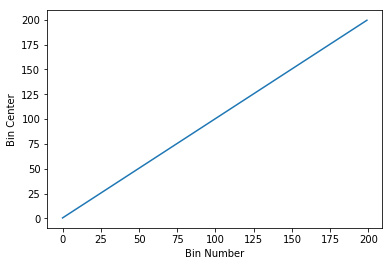

In [121]:
plt.plot(range(len(new_r_bins)),new_r_bins)
plt.ylabel('Bin Center');plt.xlabel('Bin Number');

## Save binning file

Save full binning file and $r>20$ cut

In [122]:
outfile = '/home/oliverphilcox/COMAJE/python/hybrid_binfile_fine_full.csv'
with open(outfile,'w') as out:
    for i in range(len(new_r_lo)):
        out.write("%.8f\t%.8f\n"%(new_r_lo[i],new_r_hi[i]))

In [123]:
outfile = '/home/oliverphilcox/COMAJE/python/hybrid_binfile_fine_cut.csv'
with open(outfile,'w') as out:
    for i in range(len(new_r_lo_cut)):
        out.write("%.8f\t%.8f\n"%(new_r_lo_cut[i],new_r_hi_cut[i]))

## Rebin $\xi$ functions weighting by RR

In [125]:
all_new_xi = []
for i in range(1,100):
    xi_m = compute_xi_Mariana(i)[-1]

    new_xi = np.zeros([len(new_r_bins),len(new_mu_bins)])
    xi_norm = np.zeros_like(new_xi)

    def which_rbin(r):
        for r_i in range(len(new_r_lo)):
            if ((r<new_r_hi[r_i])&(r>new_r_lo[r_i])):
                return r_i
            elif ((r_i==len(new_r_lo)-1)&(r>new_r_hi[r_i])):
                return -1

    for ri,r in enumerate(r_bins_m):
        rbin = which_rbin(r)
        if rbin!=-1:
            for mui,mu in enumerate(mu_bins_m):
                mubin=int(mu//mu_width)
                new_xi[rbin,mubin]+=xi_m[ri,mui]*all_RR_data_M[ri,mui]
                xi_norm[rbin,mubin]+=all_RR_data_M[ri,mui]
    new_xi = np.divide(new_xi,xi_norm)
    all_new_xi.append(new_xi)

## Check this worked:

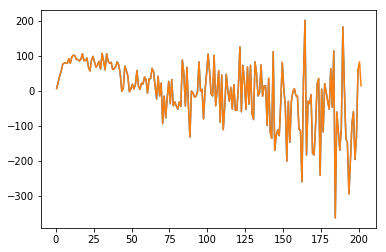

In [131]:
new_xi = all_new_xi[7]
xi_m = compute_xi_Mariana(8)[-1]
plt.plot(new_r_bins,new_r_bins**2.*new_xi[:,89])
plt.plot(r_bins_m,r_bins_m**2.*xi_m[:,89])

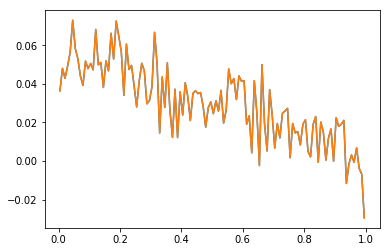

In [132]:
plt.plot(new_mu_bins,new_xi[46,:])
plt.plot(mu_bins_m,xi_m[46,:])

## Now save these to file

In [134]:
for index in range(1,100):
    outdir='/mnt/store1/oliverphilcox/QPM_xiFine/'
    with open(outdir+'QPM_mock_%d.xi'%index,"w") as outfile:
        for i in range(len(new_r_bins)):
            outfile.write("%.8e "%new_r_bins[i])
        outfile.write("\n")
        for j in range(len(new_mu_bins)):
            outfile.write("%.8e "%new_mu_bins[j])
        outfile.write("\n")
        for i in range(len(new_r_bins)):
            for j in range(len(new_mu_bins)):
                outfile.write("%.8e "%all_new_xi[index-1][i][j])
            outfile.write("\n")

## Create mean of 100 mock data:

In [135]:
mean_xi = np.mean(np.asarray(all_new_xi),axis=0)

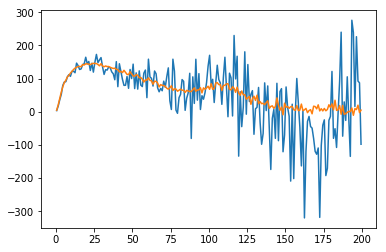

In [136]:
plt.plot(new_r_bins,new_xi[:,3]*new_r_bins**2.)
plt.plot(new_r_bins,mean_xi[:,3]*new_r_bins**2.)

In [137]:
outdir='/mnt/store1/oliverphilcox/QPM_xiFine/'
with open(outdir+'QPM_mean.xi',"w") as outfile:
    for i in range(len(new_r_bins)):
        outfile.write("%.8e "%new_r_bins[i])
    outfile.write("\n")
    for j in range(len(new_mu_bins)):
        outfile.write("%.8e "%new_mu_bins[j])
    outfile.write("\n")
    for i in range(len(new_r_bins)):
        for j in range(len(new_mu_bins)):
            outfile.write("%.8e "%mean_xi[i][j])
        outfile.write("\n")